In [1]:
import numpy as np
import matplotlib.pyplot as plt


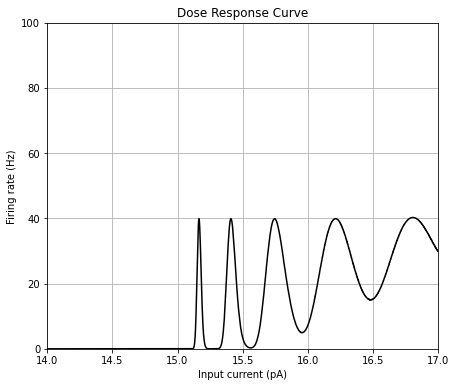

In [2]:
data = np.load('dose_response.npz')
dose_resp_x = data['x']   
dose_resp_y = data['y']
fig, ax = plt.subplots(figsize=(7, 6))
plt.plot(dose_resp_x, dose_resp_y, color='k') 
plt.xlabel('Input current (pA)')
plt.ylabel('Firing rate (Hz)')  
plt.title('Dose Response Curve')
plt.xlim(14, 17)
plt.ylim(0, 100)
plt.grid(True)


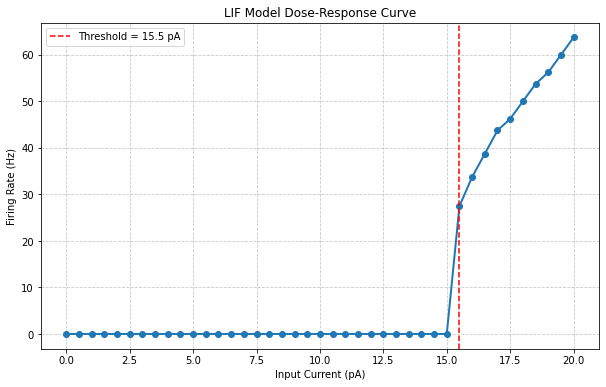

In [27]:
class CorrectedLIFModel:
    def __init__(self, dt=0.1, tau_m=20.0, V_rest=-65.0, V_th=-50.0, V_reset=-65.0,
                 R=1.0, refrac_period=2.0):
        self.dt = dt
        self.tau_m = tau_m        # 膜时间常数(ms)
        self.V_rest = V_rest      # 静息电位(mV)
        self.V_th = V_th          # 阈值电位(mV)
        self.V_reset = V_reset    # 重置电位(mV)
        self.R = R                # 膜电阻(MΩ)
        self.refrac_period = refrac_period  # 不应期(ms)
        
    def integrate(self, I_inj):
        """更准确的LIF积分"""
        n_steps = len(I_inj)
        V = np.full(n_steps, self.V_rest)
        spikes = np.zeros(n_steps)
        refrac_count = 0  # 不应期计数器
        
        for t in range(1, n_steps):
            if refrac_count > 0:
                # 不应期内保持重置电位
                V[t] = self.V_reset
                refrac_count -= self.dt
                continue
                
            # LIF微分方程: dV/dt = -(V - V_rest)/tau_m + R*I_inj[t]/tau_m
            dV = (-(V[t-1] - self.V_rest) + self.R * I_inj[t]) / self.tau_m
            V[t] = V[t-1] + dV * self.dt
            
            # 检查是否发放
            if V[t] >= self.V_th:
                spikes[t] = 1
                V[t] = self.V_reset
                refrac_count = self.refrac_period  # 进入不应期
                
        return V, spikes
def test_dose_response():
    """测试不同输入电流下的剂量响应"""
    # 创建模型 - 无适应机制
    model = CorrectedLIFModel(tau_m=10.0, V_th=-50.0, V_reset=-65.0, refrac_period=2.0)
    
    # 测试参数
    current_levels = np.arange(0, 20.1, 0.5)  # 0-20pA，步长0.5pA
    firing_rates = []
    duration = 1000  # 模拟时长1000ms
    dt = 0.1         # 时间步长0.1ms
    n_steps = int(duration / dt)
    
    for I in current_levels:
        # 恒定电流输入
        I_inj = np.full(n_steps, I)
        
        # 运行模拟
        V, spikes = model.integrate(I_inj)
        
        # 计算发放率(Hz)，忽略前200ms瞬态
        start_idx = int(200 / dt)
        spike_count = np.sum(spikes[start_idx:])
        time_sec = (n_steps - start_idx) * dt / 1000  # 转换为秒
        rate = spike_count / time_sec if time_sec > 0 else 0
        firing_rates.append(rate)
    
    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.plot(current_levels, firing_rates, 'o-', linewidth=2)
    plt.xlabel('Input Current (pA)')
    plt.ylabel('Firing Rate (Hz)')
    plt.title('LIF Model Dose-Response Curve')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 标记阈值
    threshold_idx = np.argmax(np.array(firing_rates) > 0)
    if threshold_idx > 0:
        plt.axvline(x=current_levels[threshold_idx], color='r', linestyle='--', 
                    label=f'Threshold = {current_levels[threshold_idx]:.1f} pA')
        plt.legend()
    
    plt.show()

# 运行测试
test_dose_response()

In [26]:
10000 * 3 // 4

7500